# Seminar Notebook 2.2: Clustering

**LSE MY459: Computational Text Analysis and Large Language Models** (WT 2026)

**Ryan Hübert**

This notebook covers the vector space approach and $k$-means clustering.

## Directory management

We begin with some directory management to specify the file path to the folder on your computer where you wish to store data for this notebook.

In [1]:
import os
sdir = os.path.join(os.path.expanduser("~"), "LSE-MY459-WT26", "SeminarWeek04") # or whatever path you want
if not os.path.exists(sdir):
    os.mkdir(sdir)

### Loading the DFM

We need to load the DFM we created in the last notebook. We start by reading the sparse array object we saved as an `.npz` file:

In [2]:
from scipy import sparse

sparse_dfm_file = os.path.join(sdir, 'guardian-dfm.npz')
if os.path.exists(sparse_dfm_file):
    dfm = sparse.load_npz(sparse_dfm_file)
else:
    raise ValueError("You must create the DFM using the previous notebook before proceeding!")

dfm.shape

(1959, 6236)

Next, let's load the list of features (the vocabulary), which remember is not included with the sparse array data:

In [3]:
features_file = os.path.join(sdir, 'guardian-dfm-features.txt')
vocabulary = open(features_file, mode = "r").read().split("\n")

## Calculating distance and similarity

Before we look at $k$-means clustering, let's examine how to calculate distance and similarity between documents. First, we can calculate the Euclidean and Manhattan distances between documents using the formula from lecture. Let's calculate these two distance metrics between document 0 and document 1.

In [4]:
import numpy as np

ed = np.sqrt(((dfm[0] - dfm[1]).power(2)).sum())
print(ed)

md = np.abs(dfm[0] - dfm[1]).sum()
print(md)

25.553864678361276
255.0


There is a convenient function available in `sklearn` for calculating distance. This function allows you to choose which metric you want to use, and it allows you to calculate distance between all documents (returning a matrix of pairwise distances). Let's calculate Euclidean and Manhattan distance between the first five documents. Note that Manhattan distance is called `cityblock` in `sklearn`.

In [5]:
from sklearn.metrics import pairwise_distances

edist = pairwise_distances(dfm[0:5], metric="euclidean")
print(edist)

mdist = pairwise_distances(dfm[0:5], metric="cityblock")
print(mdist)

[[ 0.         25.55386468 31.33687923 33.60059523 32.92415527]
 [25.55386468  0.         29.20616373 30.88689042 29.78254522]
 [31.33687923 29.20616373  0.         36.29049462 36.22154055]
 [33.60059523 30.88689042 36.29049462  0.         37.72267223]
 [32.92415527 29.78254522 36.22154055 37.72267223  0.        ]]
[[  0. 255. 334. 329. 422.]
 [255.   0. 289. 272. 367.]
 [334. 289.   0. 359. 466.]
 [329. 272. 359.   0. 453.]
 [422. 367. 466. 453.   0.]]


We can also calculate the cosine similarity between two documents. For example, let's look at document 0 and 1. As we can see, they are not very similar:

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

cs = cosine_similarity(dfm[0], dfm[1])  # cosine similarity
print(cs)
np.arccos(cs)                           # radians between documents
np.degrees(np.arccos(cs))               # degrees between documents

[[0.01239644]]


array([[89.28971795]])

## k-means Clustering

First, we will weight the DFM using TF-IDF weighting. Note that, by default, `TfidfTransformer` applies a normalisation to ensure that all of the vectors in the DFM have the same magnitude. The default is to apply the L2 norm, which is another way of saying the vector for each row is normalised by its vector magnitude. This is exactly what we did when we computed cosine similarity in week 3 lecture. This normalisation removes differences due purely to document length, allowing clustering to focus on differences in word composition rather than scale.

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()
dfm_tfidf = transformer.fit_transform(dfm)

Next, we will "set up" our $k$-means clustering exercise. For now, let's try to find 30 clusters and see what we get.

In [8]:
from sklearn.cluster import KMeans

K = 10
kmeans = KMeans(n_clusters=K, random_state=42) 
labels = kmeans.fit_predict(dfm_tfidf)

What objects can we extract from this? We are interested in each document $i$'s cluster assignment $\widehat{\boldsymbol{\pi}}_i$, as well as each cluster $k$'s "word usage" as represented by the centroid $\widehat{\boldsymbol{\mu}}_k$. Where can we extract those quantities from the `kmeans` and/or `labels` objects? 

### Cluster assignment 

This gives you the cluster assignments for each document:

In [9]:
cluster_assignments = labels
print(cluster_assignments)

[3 5 9 ... 2 5 9]


For example, we see that document 0 is in cluster 3. This means: $\widehat{\boldsymbol{\pi}}_0 = (0,0,1,0,0,0,0,0,0,0)$. (Remember: Python uses zero-indexing.) Let's now look at the distribution of documents across all clusters.

In [10]:
import numpy as np
import pandas as pd

cf = pd.Series(labels).value_counts()
cf = pd.concat([cf, cf / cf.sum()], axis = 1, keys=["doc_count", "doc_prop"])
cf = cf.sort_index()
cf

,doc_count,doc_prop
0,51,0.026034
1,94,0.047984
2,109,0.055641
3,161,0.082185
4,221,0.112813
5,701,0.357836
6,111,0.056662
7,74,0.037774
8,95,0.048494
9,342,0.174579


### Cluster centroid feature use

The following gives you a $K \times J$ matrix (in our case $10 \times 6236$) of cluster centroids, $\widehat{\boldsymbol{\mu}}$. Each row is a specific cluster $k$'s "average document", which we can interpret as representing the cluster's prototypical word usage.

In [11]:
mu = kmeans.cluster_centers_
print(mu)
print(mu.shape)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.00068003 ... 0.         0.         0.        ]
 ...
 [0.         0.00039359 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00213422 0.         ... 0.00296132 0.         0.        ]]
(10, 6236)


We can look at a specific cluster's centroid by extracting a row of this matrix, such as cluster 0 (the "first" cluster):

In [12]:
mu[0]

array([0., 0., 0., ..., 0., 0., 0.], shape=(6236,))

For each cluster, we can use the cluster's row in `mu` to find the top words of that cluster. More specifically, the words used the most in the cluster's centroid. Consider cluster 0. First, let's figure out which of the elements of $\boldsymbol{\mu}_0$ represent the 6 most used words in this cluster's centroid.

In [13]:
# How many "top words" do we want?
num_top_feats = 6

# Convert a row of mu to a Series object 
tf = pd.Series(mu[0]) 
# Get the top features (along with indexes)
tf = tf.nlargest(num_top_feats)
print(tf)

1230    0.352404
2940    0.105353
4926    0.085610
5633    0.070186
3128    0.069196
3430    0.066686
dtype: float64


Now let's get the _tokens_ that correspond to these `mu[0]` values, and then bind it as a column to `tf`.

In [14]:
top_words = pd.Series([vocabulary[x] for x in tf.index], index=tf.index)
tf = pd.concat([tf, top_words], axis=1, keys=["mu0_j", "j"])
tf

,mu0_j,j
1230,0.352404,corbyn
2940,0.105353,jeremi
4926,0.085610,shadow
5633,0.070186,tori
3128,0.069196,leadership
3430,0.066686,mcdonnel


Of course, we can do this for each of the clusters to get a general sense for what they are about:

In [15]:
tf = pd.DataFrame(mu) 
tf = tf.apply(pd.Series.nlargest, n=num_top_feats, axis=1)
tf = tf.reset_index().melt(id_vars="index", var_name="j", value_name="mu_kj").rename(columns={"index": "cluster"})
tf = tf.dropna(subset=["mu_kj"])
tf = tf.sort_values(["cluster", "mu_kj"], ascending=[True, False])
tf = tf.reset_index(drop=True)
tf["feature"] = [vocabulary[x] for x in tf["j"]]

top_words = tf.groupby("cluster")["feature"].apply(lambda s: ", ".join(s.astype(str)))

for i,r in top_words.items():
    print(f"Cluster {i} top words: {r}")

Cluster 0 top words: corbyn, jeremi, shadow, tori, leadership, mcdonnel
Cluster 1 top words: syria, syrian, isi, refuge, un, saudi
Cluster 2 top words: oil, uncertainti, inflat, pound, investor, forecast
Cluster 3 top words: hospit, doctor, nhs, patient, shoot, junior
Cluster 4 top words: johnson, refuge, migrant, bori, tori, khan
Cluster 5 top words: drug, violenc, sexual, girl, obama, prison
Cluster 6 top words: clinton, sander, cruz, hillari, rubio, berni
Cluster 7 top words: turnbul, labor, australian, shorten, coalit, malcolm
Cluster 8 top words: retail, store, bhs, profit, pension, properti
Cluster 9 top words: climat, appl, energi, water, googl, food


### Calculating clusters discriminating words

We can also calculate the discriminating words of each cluster using `sklearn`'s function `chi2`, which calculate the Pearson's chi2 statistic from lecture 3. Let's start by doing it for one cluster to see the basic process.

In [16]:
from sklearn.feature_selection import chi2

target = cluster_assignments == 0  # cluster 0 versus all other clusters
scores, pvals = chi2(dfm, target)  # chi2 against null hypothesis (for all features at once)

# Now let's format nicely
disc_words = pd.DataFrame({"cluster": 0, "feature": vocabulary, "chi2" : scores, "pval" : pvals})
disc_words = disc_words.sort_values("chi2", ascending=False)
print(disc_words)

      cluster        feature          chi2           pval
1230        0         corbyn  12874.298157   0.000000e+00
2940        0         jeremi   2633.643749   0.000000e+00
4926        0         shadow   2037.390067   0.000000e+00
3430        0       mcdonnel   1493.286777   0.000000e+00
5701        0        trident   1345.861385  1.221888e-294
...       ...            ...           ...            ...
5640        0          tough      0.000013   9.971378e-01
6070        0         weight      0.000011   9.973766e-01
4574        0          remot      0.000011   9.973766e-01
4542        0         regret      0.000011   9.973766e-01
1986        0  extraordinari      0.000011   9.973766e-01

[6236 rows x 4 columns]


Now, let's plot a bar chart depicting the top 10 most discriminating words for cluster 0.

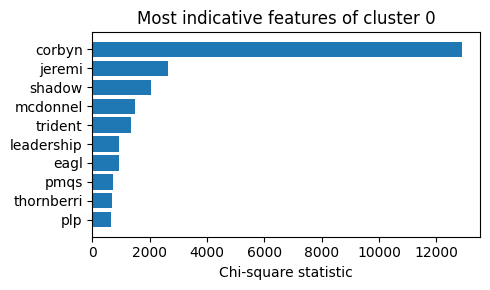

In [17]:
import matplotlib.pyplot as plt

top = disc_words.nlargest(10, "chi2").sort_values("chi2")

plt.figure(figsize=(5, 3))
plt.barh(top["feature"], top["chi2"])
plt.xlabel("Chi-square statistic")
plt.ylabel("")
plt.title("Most indicative features of cluster 0")
plt.tight_layout()
plt.show()

Now, we do it for all clusters.

In [18]:
dwf = pd.DataFrame()

for cluster in range(K):
    target = cluster_assignments == cluster
    scores, pvals = chi2(dfm, target)
    disc_words = pd.DataFrame({"cluster": cluster, "feature": vocabulary, "chi2" : scores, "pval" : pvals})
    disc_words = disc_words.sort_values("chi2", ascending=False).iloc[0:num_top_feats,:]
    disc_words = disc_words.loc[disc_words["pval"] < 0.05,:]
    dwf = pd.concat([dwf, disc_words], axis = 0)

disc_words = dwf.groupby("cluster")["feature"].apply(lambda s: ", ".join(s.astype(str)))

for i,r in disc_words.items():
    print(f"Cluster {i} most discriminating words: {r}")

Cluster 0 most discriminating words: corbyn, jeremi, shadow, mcdonnel, trident, leadership
Cluster 1 most discriminating words: syria, isi, syrian, aleppo, saudi, humanitarian
Cluster 2 most discriminating words: oil, pound, crude, investor, output, opec
Cluster 3 most discriminating words: doctor, nhs, hospit, patient, junior, isra
Cluster 4 most discriminating words: migrant, refuge, johnson, khan, brake, tusk
Cluster 5 most discriminating words: clinton, sander, drug, sexual, prison, abus
Cluster 6 most discriminating words: clinton, sander, cruz, hillari, berni, ted
Cluster 7 most discriminating words: turnbul, labor, shorten, malcolm, australian, abbott
Cluster 8 most discriminating words: retail, bhs, landlord, mortgag, pension, tenant
Cluster 9 most discriminating words: climat, appl, googl, energi, app, iphon
